# Setup

In [2]:
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image

#pytorch libraries

#other libraries
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

cuda


# Loading the data into a dataset class

In [3]:
pokemon_info = pd.read_csv('../datasets/processed/pokemon.csv')
pokemon_info.head()

,name,image,type1,type2,dex
0,bulbasaur,../datasets/raw/renders_2d/images/1.png,grass,poison,1
1,ivysaur,../datasets/raw/renders_2d/images/2.png,grass,poison,2
2,venusaur,../datasets/raw/renders_2d/images/3.png,grass,poison,3
3,charmander,../datasets/raw/renders_2d/images/4.png,fire,NaN,4
4,charmeleon,../datasets/raw/renders_2d/images/5.png,fire,NaN,5


## OneHot encoding the Types

In [4]:
def onehot(df):
    """Use df to:
     - Create unique list of pokemon types
     - Loop through Type1 and Type2 column
     - Create one-hot encoding for each type
     - Return one-hot encoding for each type as numpy array"""

    all_types = df['type1'].to_list() + df['type2'].to_list()
    uniques = list(set(all_types))
    uniques = [ x for x in uniques if isinstance(x, str) ] # remove nan by keeping only strings
    
    onehot = np.zeros((len(df), len(uniques)))
    for i, row in df.iterrows():
        type1 = row['type1']
        type2 = row['type2']

        # only work with non nan
        if isinstance(type1, str):
            onehot[i, uniques.index(type1)] = 1
        if isinstance(type2, str):
            onehot[i, uniques.index(type2)] = 1

    return onehot, uniques

In [6]:
onehot_enc, uniques = onehot(pokemon_info)
print(onehot_enc.shape)
print(uniques)

(704, 18)
['ground', 'rock', 'grass', 'bug', 'fighting', 'poison', 'dragon', 'electric', 'steel', 'normal', 'ice', 'flying', 'fairy', 'fire', 'dark', 'ghost', 'psychic', 'water']


Helper function for showing a pokemon and its name and types

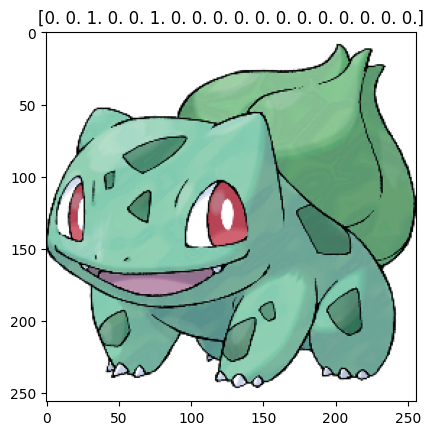

In [7]:
def show_pokemon(image, types):
    """Show image with name, types and evolution of pokemon"""
    plt.imshow(image)
    plt.title(str(types))
    plt.pause(0.001)  # pause a bit so that plots are updated

show_pokemon(Image.open(pokemon_info['image'][0]),
               onehot_enc[0])

In [9]:
class PokemonDataset(Dataset):
    """Pokemon dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.pokemon_info = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.pokemon_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # img_name = os.path.join(self.root_dir, str(idx+1) + '.png')
        img_name = self.pokemon_info['image'][idx]
        image = Image.open(img_name).convert('RGB')
        # image = np.asarray(image)

        # onehot encode the types
        # sample = {'image': image, 'types': onehot_enc[idx]}

        if self.transform:
            image = self.transform(image)

        return image, onehot_enc[idx]

Let’s instantiate this class and iterate through the data samples. We will print the sizes of first 4 samples and show their landmarks.

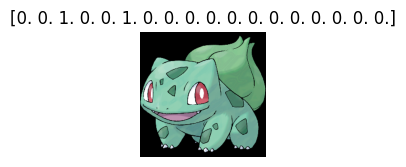

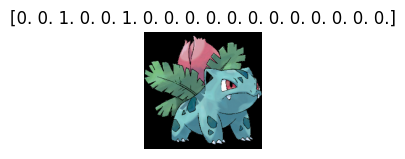

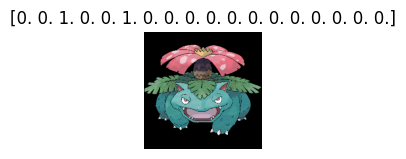

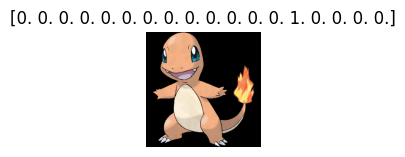

In [10]:
pokemon_dataset = PokemonDataset(csv_file='../datasets/processed/pokemon.csv',
                                 root_dir='../datasets/raw/renders_2d/images/')

fig = plt.figure()

for i, (image, types) in enumerate(pokemon_dataset):

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_pokemon(image, types)

    if i == 3:
        plt.show()
        break

# Transform to Tensors

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [12]:
transformed_dataset = PokemonDataset(csv_file='../datasets/processed/pokemon.csv',
                                     root_dir='../datasets/raw/renders_2d/images/',
                                     transform=transform)

for i, (image, types) in enumerate(transformed_dataset):
    print(i, image.size())
    if i == 0:
        break

0 torch.Size([3, 256, 256])


# Save dataloader and encoding mappings

In [13]:
train_set, val_set = torch.utils.data.random_split(transformed_dataset, [0.9, 0.1])

In [14]:
train_loader = DataLoader(train_set, batch_size=8,
                        shuffle=True, num_workers=2)

val_loader = DataLoader(val_set, batch_size=8,
                        shuffle=False, num_workers=2)


In [15]:
for (image, types) in train_loader:
    print(image.size())
    print(image.size())
    break

torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])


In [131]:
class AutoEncoder(nn.Module):
    def __init__(self, hidden_dim=64, latent_dim=128, num_classes=1):
        super().__init__()
        self.num_classes = num_classes
        self.encoder = nn.Sequential(
            nn.Conv2d(3, hidden_dim//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(hidden_dim//2, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(hidden_dim, latent_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, hidden_dim//2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim//2, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x, y):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

In [132]:
auto_encoder = AutoEncoder(num_classes=len(uniques))

auto_encoder.to(device)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(auto_encoder.parameters(), lr=1e-5)

In [133]:
#training process

epochs = 500
outputs = []

loss_list = []
 

for epoch in range(1,epochs+1):
    loss_avg = 0
    for i, data in enumerate(train_loader, start=1):
        
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # print(images.shape)
        # print(labels.shape)
        
        recon = auto_encoder(images, y=labels)
        # print(recon.shape)
        
        loss = loss_fn(recon, images)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_avg += loss.item()
    loss_avg = loss_avg / len(train_loader)
    loss_list.append(loss_avg)
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss_avg:.4f}')  
    outputs.append((epoch, images, recon))

Epoch [10/500], Loss: 0.0515
Epoch [20/500], Loss: 0.0252
Epoch [30/500], Loss: 0.0200
Epoch [40/500], Loss: 0.0179
Epoch [50/500], Loss: 0.0166
Epoch [60/500], Loss: 0.0156
Epoch [70/500], Loss: 0.0148
Epoch [80/500], Loss: 0.0143
Epoch [90/500], Loss: 0.0137
Epoch [100/500], Loss: 0.0133
Epoch [110/500], Loss: 0.0129
Epoch [120/500], Loss: 0.0126
Epoch [130/500], Loss: 0.0121
Epoch [140/500], Loss: 0.0111
Epoch [150/500], Loss: 0.0101
Epoch [160/500], Loss: 0.0095
Epoch [170/500], Loss: 0.0092
Epoch [180/500], Loss: 0.0089
Epoch [190/500], Loss: 0.0087
Epoch [200/500], Loss: 0.0085
Epoch [210/500], Loss: 0.0084
Epoch [220/500], Loss: 0.0082
Epoch [230/500], Loss: 0.0081
Epoch [240/500], Loss: 0.0080
Epoch [250/500], Loss: 0.0080
Epoch [260/500], Loss: 0.0079
Epoch [270/500], Loss: 0.0078
Epoch [280/500], Loss: 0.0077
Epoch [290/500], Loss: 0.0076
Epoch [300/500], Loss: 0.0074
Epoch [310/500], Loss: 0.0073
Epoch [320/500], Loss: 0.0072
Epoch [330/500], Loss: 0.0071
Epoch [340/500], Lo

In [1]:


for i, data in enumerate(val_loader):
    (images, labels) = data
    # fire_type = torch.tensor(onehot_enc[3])
    # test_labels = fire_type.repeat(8, 1)
    # test_labels.to(device)
    images, labels = images.to(device), labels.to(device)
    print(images.shape)
    # images_reshaped = images.reshape(-1, 32*32)
    recon = auto_encoder(images, labels).to(device)
    break
fig, ax = plt.subplots(4, 2, figsize=(10,10))
for i in range(4):
    ax[i,0].imshow(images[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[i,1].imshow(recon[i].permute(1, 2, 0).cpu().detach().numpy())
plt.tight_layout()

NameError: name 'val_loader' is not defined